# modis_hdf2nc

In [42]:
# Creates a NetCDF file from a collection of MODIS observations.

# Input datasets (HDF format):
# - MxD021KM ()
# - MxD03 (MODIS Geolocation Fields 5-Min L1A Swath 1km)

import xarray as xr
import numpy as np
import os
import pandas as pd
import gdal
import glob

import matplotlib.pyplot as plt


In [2]:
modis_dir = '/storage/MODIS/Tuolumne_MOD021KM'
geo_dir = '/storage/MODIS/Tuolumne_MOD03'

modis_searchDir = os.path.normpath(modis_dir)
geo_searchDir = os.path.normpath(geo_dir)

In [3]:
#-----------------------READ IN FILES----------------------------#
print('\n')

# Search specified directories for HDF files
modis_file_list = glob.glob(modis_searchDir+'/**/*.hdf', recursive=True)
modis_geo_file_list =  glob.glob(geo_searchDir+'/**/*.hdf', recursive=True)

print('Found {} MODIS files, {} GEO files'.format(len(modis_file_list),len(modis_geo_file_list)))



Found 89 MODIS files, 89 GEO files


Pair the MOD021KM and MOD03 products based on their timestamps:

In [4]:
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

def modis_filepath_dict(modis_file_list, filepath_column_name='filepath'):
    '''Given a list of MxD021KM or MxD03 filepaths, parse out the timestamps and arrange into a dictionary'''
    
    # create an empty dictionary we'll fill with filenames and timestamps for each MOD021KM image we have
    modis_dict = {}
    
    # loop through each filepath in the list
    for this_modis_file in modis_file_list:
        # get just the filename
        this_modis_filename = os.path.normpath(this_modis_file).split('/')[-1]
        # then parse the year, day of year, hour, and minutes from the MOD021KM filename
        this_modis_date_time = this_modis_filename.split('.')[1] + this_modis_filename.split('.')[2]
        this_modis_timestampUTC = pd.to_datetime(this_modis_date_time[1:], format="%Y%j%H%M")
        this_modis_timestampUTC = pd.Timestamp(this_modis_timestampUTC, tz='UTC') #also specify UTC
        # add these to our dictionary, use the date as the key
        modis_dict[this_modis_timestampUTC] = {}
        modis_dict[this_modis_timestampUTC][filepath_column_name] = this_modis_file
    
    return modis_dict

In [5]:
mod021km_dict = modis_filepath_dict(modis_file_list, 'MOD021KM_filepath')
mod03_dict = modis_filepath_dict(modis_geo_file_list, 'MOD03_filepath')
# make a dataframe from the mod03 dict
modis_df = pd.DataFrame.from_dict(mod03_dict, orient ='index')
# reset the index
modis_df.reset_index(inplace=True)
# rename the old index column
modis_df.rename(columns = {'index':'MOD03_timestampUTC'}, inplace = True) 

In [6]:
modis_df['MOD021KM_timestampUTC'] = np.empty_like(modis_df.MOD03_timestampUTC)
modis_df['MOD021KM_filepath'] = np.empty_like(modis_df.MOD03_filepath)

for i in range(len(modis_df)):

    nearest_mod021km_timestampUTC = nearest(list(mod021km_dict.keys()), modis_df.MOD03_timestampUTC[i])

    #print('MOD021KM: {}\nMOD03: {}\n\n'.format(nearest_modis_timestampUTC, modis_df.MOD03_timestampUTC[i]))
    
    modis_df['MOD021KM_timestampUTC'][i] = nearest_mod021km_timestampUTC
    modis_df['MOD021KM_filepath'][i] = mod021km_dict[nearest_mod021km_timestampUTC]['MOD021KM_filepath']

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  """Entry point for launching an IPython kernel.
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarni

Create new combined NetCDF files from each pair of MOD021KM and MOD03 files:

In [8]:
err=0
err_g=0
for i, row in modis_df.iterrows():
    # ----- Open MOD021KM ----- 
    try:
        modis_ds = gdal.Open('HDF4_SDS:UNKNOWN:"{}":4'.format(row.MOD021KM_filepath))
    except RuntimeError as e:
        print(e)
        print(path)
        print('HDF4_SDS:UNKNOWN::"{}":4'.format(row.MOD021KM_filepath))
        err = err+1
        
    # ----- Open MOD03 ----- 
    print('{}/{}'.format(i,len(modis_geo_file_list)), end="\r")
    try:
        geo_lat_ds = gdal.Open('HDF4_SDS:UNKNOWN:"{}":0'.format(row.MOD03_filepath))
        geo_lon_ds = gdal.Open('HDF4_SDS:UNKNOWN:"{}":1'.format(row.MOD03_filepath))
    except RuntimeError as e:
        print(e)
        print(path)
        print('HDF4_SDS:UNKNOWN:"{}":0'.format(row.MOD03_filepath))
        print('HDF4_SDS:UNKNOWN:"{}":1'.format(row.MOD03_filepath))
        #_ = input()
        err_g = err_g+1
        
    
    
    #-----------------------STACK DATA----------------------------#
    # Match geolocation with LST products, stack into xarray dataset.

    # Because the MODIS products are either 2030 or 2040 pixels in 5 minutes...
    # I'm truncating them all to just 2030
    along_track_px = 2030
    cross_track_px = 1354
    
    # MOD021KM scale factor
    modis_scale_factor = 1.0
    # TODO: alternatively, scale (and offset) factors should be pulled from HDF file metadata
    
    # Read the date and time from the MOD021KM product
    date = modis_ds.GetMetadataItem('RANGEBEGINNINGDATE')
    time = modis_ds.GetMetadataItem('RANGEBEGINNINGTIME')
    eq_cross_time = modis_ds.GetMetadataItem('EQUATORCROSSINGTIME.1')
        
    # For the matching MxD03 Geolocation product
    eq_cross_time_geo = geo_lat_ds.GetMetadataItem('EQUATORCROSSINGTIME.1')
            
    # Make sure these actually match
    assert eq_cross_time==eq_cross_time_geo, "EQUATORCROSSINGTIMEs do not match!"
    # TODO: use metadata item "AncillaryInputPointer" to find the corresponding geolocation product           
                 
    # Load the data values and scale them
    data = modis_scale_factor * modis_ds.ReadAsArray()[:,0:along_track_px,0:cross_track_px]
    
    # Replace the nodata value 0, with Nans
    #values[values==0.] = np.nan
    
    ## Read the view angles from the LST product, scale and remove nodata values
    #viewangle = viewangle_ds[i].ReadAsArray()[0:along_track_px,0:cross_track_px].astype(float)
    #viewangle[viewangle==255] = np.nan
    #viewangle = view_scale_factor * viewangle
    
    # Read the latitudes and longitudes from the geolocaiton product
    lat = geo_lat_ds.ReadAsArray()[0:along_track_px,0:cross_track_px]    
    lon = geo_lon_ds.ReadAsArray()[0:along_track_px,0:cross_track_px]
    
    # Add the MODIS data to an xarray dataset
    ds = xr.Dataset({'data': (['band', 'line', 'pixel'],  data)#,
                    #'viewangle': (['line', 'pixel'],  viewangle)
                    },
                    coords={'band': range(data.shape[0]),
                            'longitude': (['line', 'pixel'], lon),
                            'latitude': (['line', 'pixel'], lat)},
                    #attrs={'time': pd.to_datetime('{} {}'.format(date,time))}
                   )


        
    # Now lose the original HDF files we loaded
    modis_ds = None
    #viewangle_ds = None
    geo_lat_ds = None
    geo_lon_ds = None
    
    # Save this file out
    new_filename = row.MOD021KM_filepath.split('/')[-1][:-4] + ".nc"
    new_filepath = '/storage/MODIS/nc/Tuolumne_MOD021KM_MOD03_nc/'
    ds.to_netcdf(new_filepath+new_filename,mode='w')
    
print('LST err: {}\nGEO err:{}'.format(err,err_g))

LST err: 0
GEO err:0


---
---
---
Open one of the files I just made

In [49]:
ds = xr.open_dataset('/storage/MODIS/nc/Tuolumne_MOD021KM_MOD03_nc/MOD021KM.A2018283.0505.061.2018283134821.nc')

In [50]:
ds

<xarray.Dataset>
Dimensions:    (band: 16, line: 2030, pixel: 1354)
Coordinates:
  * band       (band) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    longitude  (line, pixel) float32 ...
    latitude   (line, pixel) float32 ...
Dimensions without coordinates: line, pixel
Data variables:
    data       (band, line, pixel) float64 ...

In [51]:
ds.data

<xarray.DataArray 'data' (band: 16, line: 2030, pixel: 1354)>
[43977920 values with dtype=float64]
Coordinates:
  * band       (band) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    longitude  (line, pixel) float32 ...
    latitude   (line, pixel) float32 ...
Dimensions without coordinates: line, pixel

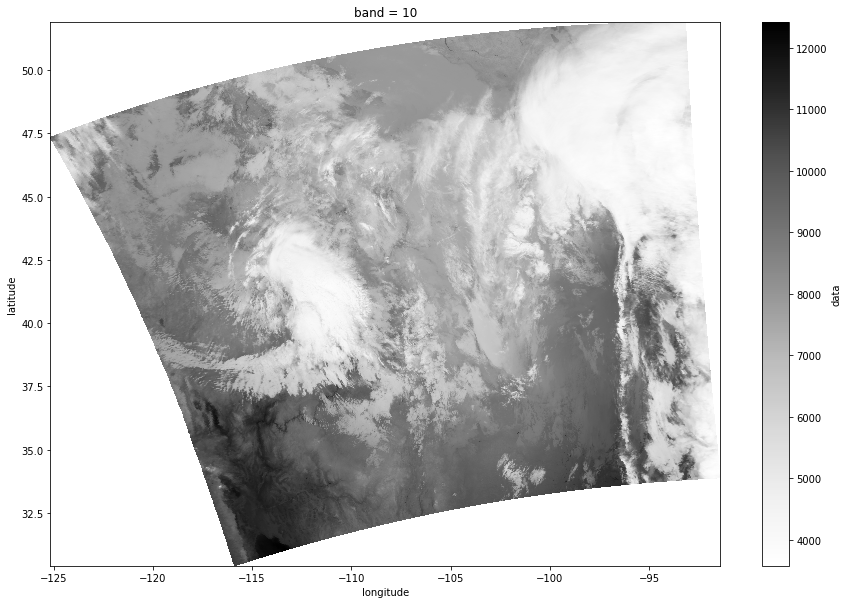

In [53]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ds.isel(band=10).data.plot(x='longitude', y='latitude', ax=ax, cmap="Greys")